# Query Based Summarisation using Vector Space

Use of Vector space
The primary shortcoming associated with text summarization is redundancy, where more than one sentence representing a similar type of information are incorporated in summary
So the vector space uses the vectors of either Bag-of-words of tf-idf and use them to find cosine similarities to do the summarization 

Limitations:
1. Long documents are poorly represented because they have poor similarity values (a small scalar product and a large dimensionality)
2. Search keywords must precisely match document terms; word substrings might result in a "false positive match"
3. Semantic sensitivity; documents with similar context but different term vocabulary won't be associated, resulting in a "false negative match".
4. The order in which the terms appear in the document is lost in the vector space representation.
Theoretically assumes terms are statistically independent.
5. Weighting is intuitive but not very formal.


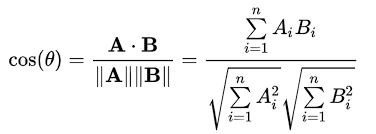

In [47]:
import numpy as np
import pandas as pd
import nltk
import re
from gensim.models import Word2Vec
from scipy import spatial
import networkx as nx
from nltk.tokenize import sent_tokenize
import spacy

## Reading The Text File
we wil start by reading the test file by using python file handeling and copy its content to a python variable so as to work on it

In [48]:
f = open("welcome.txt", "r")
f.seek(0)
text=f.read()

## Converting text into sentences
We need to convert the whole text into sentences so that we can find out similarity between them and then crreate an extractive summary by using those sentences
We will use NLTK for this task as the text to sentence conversion in nltk is fast and reliable

In [49]:
sentences1 = sent_tokenize(text)

In [50]:
sentences1

["Natural Language Processing (NLP) is an important tool for understanding and\nprocessing the immense volume of unstructured data in today's world.",
 'Recently,\ndeep learning has been widely adopted for many NLP tasks because of the\nremarkable performance that deep learning algorithms have shown in a plethora\nof challenging tasks, such as, image classification, speech recognition, and realistic\ntext generation.',
 'TensorFlow, in turn, is one of the most intuitive and efficient deep\nlearning frameworks currently in existence.',
 'This book will enable aspiring deep\nlearning developers to handle massive amounts of data using NLP and TensorFlow.',
 'In this chapter, we will provide an introduction to NLP and to the rest of the book.',
 'We will answer the question, "What is Natural Language Processing?"',
 "Also, we'll\nlook at some of its most important uses.",
 'We will also consider the traditional\napproaches and the more recent deep learning-based approaches to NLP, includin

#### Loading Spacy 

In [51]:
nlp=spacy.load('en_core_web_sm')
from spacy.lang.en.stop_words import STOP_WORDS

## Creating a function for text preprocessing and cleaning
Preprocessing text data is one of the most difficult tasks in Natural Language processing because there are no specific statistical guidelines available. It is also extremely important at the same time.

For this Model we will be removing stop words, special symbols and converting to lower case and doing some basic processing of urls using the re library of python for regular expressin

In [25]:

def clean(text):
    text=text.strip().lower()
    # Remove the characters - <>()|&©ø"',;?~*!
    text = re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", " ", str(text)).lower()
    
    # Replace any url to only the domain name
    try:
        url = re.search(r"((https*:\/*)([^\/\s]+))(.[^\s]+)", str(text))
        repl_url = url.group(3)
        text = re.sub(r"((https*:\/*)([^\/\s]+))(.[^\s]+)", repl_url, str(text))
    except:
        pass
    doc=nlp(text)
    clean_sentences =[token.text for token in doc if not token.is_punct and not token.is_stop]
    return clean_sentences

Cleaning all sentences iteratively

In [26]:
sentences=[]
for i in range(len(sentences1)):
    sentences.append(clean(sentences1[i]))

### Creating a dictionary to keep the order of sentences
We will use enumrate and dictionary to create a integer key for each sentence which will later help to keep track of thr order of sentences

In [27]:
dict_sent={}

In [28]:
for i,j in enumerate(sentences1):
    dict_sent[i]=j

In [29]:
dict_sent

{0: "Natural Language Processing (NLP) is an important tool for understanding and\nprocessing the immense volume of unstructured data in today's world.",
 1: 'Recently,\ndeep learning has been widely adopted for many NLP tasks because of the\nremarkable performance that deep learning algorithms have shown in a plethora\nof challenging tasks, such as, image classification, speech recognition, and realistic\ntext generation.',
 2: 'TensorFlow, in turn, is one of the most intuitive and efficient deep\nlearning frameworks currently in existence.',
 3: 'This book will enable aspiring deep\nlearning developers to handle massive amounts of data using NLP and TensorFlow.',
 4: 'In this chapter, we will provide an introduction to NLP and to the rest of the book.',
 5: 'We will answer the question, "What is Natural Language Processing?"',
 6: "Also, we'll\nlook at some of its most important uses.",
 7: 'We will also consider the traditional\napproaches and the more recent deep learning-based app

## Word to Vec
we need to convert the sentences to vectors, there may be different choices to create vectors from sentences such as bag_of_words, Tf_idf and glove library but here we will be using gensim library provided by google.

Word embedding by Word2Vec involves analysis of the learned vectors as well as exploration of vector math on representation of words. Following are the two different learning methods which can be used as the part of Word2Vec method −

1. CBoW(Continuous Bag of Words) Model

2. Continuous Skip-Gram Model

With Gensim, it is extremely straightforward to create Word2Vec model. The word list is passed to the Word2Vec class of the gensim.models package. We need to specify the value for the min_count parameter. 


In [30]:
w2v=Word2Vec(sentences,min_count=1)

## Giving query for summarisation
we need to provide some query to create a summary according to that, we will be using cosine similarity to find relation between query and different sentences.

In [31]:
text= "Natural Language processing"
text=clean(text)

Creating vector for the query to find the cosine similarity

In [55]:
w1v=Word2Vec(text,min_count=1)

In [74]:
sentence_embeddings=[[w2v.wv[word][0] for word in words] for words in sentences]


In [75]:
sentence_embeddings1=[[w1v.wv[word][0] for word in words] for words in text]


In [76]:
max_len=max([len(tokens) for tokens in sentences])

Padding the vectors to make them the same size

In [77]:
sentence_embeddings=[np.pad(embedding,(0,max_len-len(embedding)),'constant') for embedding in sentence_embeddings]

In [78]:
sentence_embeddings1=[np.pad(embedding,(0,max_len-len(embedding)),'constant') for embedding in sentence_embeddings1]

In [79]:
similarity_matrix = np.zeros([len(sentences), len(text)])

In [80]:
dict_sent1={}

## Finding Cosine Similarity

In [81]:
for i,row_embedding in enumerate(sentence_embeddings):
    for j,column_embedding in enumerate(sentence_embeddings1):
        similarity_matrix[i][j]=1-spatial.distance.cosine(np.array(row_embedding).flatten(),np.array((column_embedding).flatten()))
    dict_sent1[sum(similarity_matrix[i])]=i

In [82]:
def sum_sort(x):
    return sum(x)

In [83]:
top_keys=sorted(similarity_matrix, key=lambda item: (-sum(item)))[:5]

In [84]:
print(dict_sent1)

{211.92782945930958: 0, -170.8697426021099: 1, 65.35187520831823: 2, -225.78006963431835: 3, -757.003908097744: 4, 7.538168091792613: 5, 63.46328965574503: 6, 65.23285585641861: 7, 100.7993291541934: 8, -150.73883859813213: 9, 348.3876838982105: 10, 286.4971527457237: 11, -4.470851549413055: 12, 511.1533072590828: 13, 83.03007890284061: 14, -322.8577478826046: 15, -303.55905851721764: 16, 49.06436725705862: 17, 30.10973641462624: 18, 46.89130864664912: 19, -62.19360249489546: 20, 66.69086050242186: 21, 595.6991585493088: 22, 52.46134228631854: 23, 485.49797877669334: 24, 26.9269644562155: 25, -319.0894936323166: 26, -123.8702063858509: 27, 361.8152315914631: 28}


In [85]:
for i in range(len(top_keys)):
    top_keys[i]=sum(top_keys[i])

Finally printing the sentences most accurate and near to the query

In [86]:
for i in similarity_matrix:
    for j in top_keys:
        if sum(i)==j:
            print(dict_sent[dict_sent1[j]])

To
put that into perspective, if all the human beings in the world were to process that
data, it would be roughly 300 MB for each of us every day to process.
Simply put, the
goal of NLP is to make machines understand our spoken and written languages.
This
example shows that NLP has become an integral part of human life.
To
make matters worse, each language has its own grammar, syntax, and vocabulary.
Machine learning has become a key enabler for NLP, helping to
accomplish the aforementioned tasks through machines.
